# Author: Samuel Hickey

### Word-level (notes and chords treated as singular words) Music Generating RNN
### Version 3.1: seq2seq

In version 1, we followed the Tensorflow tutorial from Magenta to attempt to generate Music using RNNs.

In version 2, we will diverge from the approach of V1 and attempt to generate notes in a manner similar to generating sentences in NLP.
We will train the model using next word prediction. Our vocabulary will consist of all notes and note combinations found in the Maestro v2 dataset (~12000 different combinations)

In version 3.0 we:
- removed one-hot encoding of the targets
- instead of only providing the next note as a target, we used the next sequence.
- refactored the model structure to a class
- modified the generation process to match the new structure

In this version, 3.1, we will:
- simplify the encoder
- add an attention layer
- add a decoder

## Imports

In [1]:
import collections
import glob
import keras
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import warnings

from numba import jit
from keras.layers import (BatchNormalization, Bidirectional, CategoryEncoding, Embedding, Dense, Dropout, LSTM)
from keras.utils import timeseries_dataset_from_array
from keras.preprocessing.text import Tokenizer
from utilities.DatasetUtils import (midi_to_notes, plot_piano_roll)

warnings.filterwarnings("ignore")

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

SEQ_LEN = 128

### Select Dataset

In [2]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
filenames = glob.glob(str(data_dir/'*/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


### Extract the Notes

For each song, we round the start times of each note to the nearest one-thousandth of a second and consider any notes with the same start time to be a chord i.e. a new term in our vocabulary. Each step contains at least one key and as many as seven keys.

In [3]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
	pm = pretty_midi.PrettyMIDI(midi_file)
	instrument = pm.instruments[0]
	notes = collections.defaultdict(list)

	# Sort the notes by start time
	sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
	
	notes['pitch'].append('START')
	notes['start'].append(0)
	for note in sorted_notes:
		notes['pitch'].append(pretty_midi.note_number_to_name(note.pitch))
		notes['start'].append(round(note.start, 3))
	notes['pitch'].append('END')
	notes['start'].append(round(note.start, 2) + 3)

	result = pd.DataFrame({name: np.array(value) for name, value in notes.items()})	
	result = result.groupby('start').agg({'pitch': sorted}).reset_index()
	result.pitch = result.pitch.str.join(',')
	return result
tf.strings.

In [4]:
# Load the files
num_files = 50  # len(filenames)
all_notes, vocab = [], []
for f in filenames[:num_files]:
    df = midi_to_notes(f)
    all_notes.append(df)

### Save Notes, Vocabulary, Character Indices

In [5]:
# SAVE NOTES AND VARS
# vocab = np.unique(pd.concat(all_notes).pitch.to_numpy())
# ids_from_chars = {v:k for k, v in enumerate(vocab)}
# chars_from_ids = {k:v for k, v in enumerate(vocab)}
# np.save(
#     pathlib.Path('data/preprocessed/vocab_ids_chars.npy'),
#     [vocab, ids_from_chars, chars_from_ids],
#     allow_pickle=True
# )

# all_notes = np.array([padded_song(song) for song in all_notes])
# np.save(
#     pathlib.Path('data/preprocessed/sample_notes.npy'),
#     all_notes,
#     allow_pickle=True
# )

### Load Notes, Vocabulary, Character Indices

As mentioned earlier, the vocabulary and character indices were created using ALL of the available midi files in the Maestro V2 dataset. However, "all_notes" consists only of all the notes found in the files we chose to use i.e. num_files

In [6]:
vocab, ids_from_chars, chars_from_ids = np.load(
	'data/preprocessed/vocab_ids_chars.npy',
	allow_pickle=True
)  # This file was built using all available input files 

all_notes = pd.concat(all_notes).pitch \
	.map(lambda note: ids_from_chars[note]) \
	.reset_index() \
	.pitch

### Create Dataset

Here we are using time_series_dataset_from_array to create batches of sequences that have a length of SEQ_LEN. Next, we map each batch through the split_input_target function to create an input and a target of shape (batch_size, SEQ_LEN-1).

It is important to our understanding that we realize time_series_dataset_from_array will take a sequence of events [x1, x2, ...,  x_n] and produce a tensor of sequences: 

[[x1, x2, ..., x_seq_len], 
<br>[x_seq_len, x_seq_len+1, ..., x_seq_len*2],
<br>[  ...  ]
<br>[x_n-seq_len, x_n+1-seq_len, ..., x_n]]

Where [x_n-seq_len, x_n+1-seq_len, ..., x_n]] is the last sequence in the batch and n = k*(batch_size*seq_len) for some natural number, k.

In [20]:
def split_input_target(seq):
    layer = CategoryEncoding(num_tokens=len(vocab)+1, output_mode="one_hot")
    inputs, targets = seq[:, :-1], seq[:, 1:]
    return (
        inputs,
        layer(targets)
    )
dataset = timeseries_dataset_from_array(all_notes, None, SEQ_LEN, batch_size=64) \
    .map(split_input_target)

### Model Definition and Initialization

In [22]:
# EXPERIMENTAL
model = keras.models.Sequential([
    Embedding(len(vocab)+1, 128, input_length=SEQ_LEN),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(.2),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(.2),
    Bidirectional(LSTM(512)),
    Dropout(.2),
    Dense(512, activation='relu'),
    Dense(len(vocab)+1, activation='softmax')
])

In [23]:
# model = keras.models.Sequential([
#     Embedding(len(vocab)+1, 128, input_length=SEQ_LEN),
#     Bidirectional(LSTM(128, return_sequences=True)),
#     Dropout(.2),
#     Bidirectional(LSTM(128)),
#     Dropout(.2),
#     Dense(128, activation='relu'),
#     Dense(len(vocab)+1, activation='softmax')
# ])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=.5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy')

### Training

In [24]:
history = model.fit(dataset, epochs=200, callbacks=callbacks)

Epoch 1/200
4554/4554 [==============================] - 471s 102ms/step - loss: 4.2017
Epoch 2/200
4554/4554 [==============================] - 463s 102ms/step - loss: 4.1491
Epoch 3/200
4554/4554 [==============================] - 465s 102ms/step - loss: 4.1318
Epoch 4/200
4554/4554 [==============================] - 462s 101ms/step - loss: 4.0805
Epoch 5/200
4554/4554 [==============================] - 463s 102ms/step - loss: 4.0126
Epoch 6/200
4554/4554 [==============================] - 465s 102ms/step - loss: 3.9431
Epoch 7/200
4554/4554 [==============================] - 465s 102ms/step - loss: 3.9025
Epoch 8/200
4554/4554 [==============================] - 464s 102ms/step - loss: 3.8483
Epoch 9/200
4554/4554 [==============================] - 464s 102ms/step - loss: 3.7882
Epoch 10/200
4554/4554 [==============================] - 464s 102ms/step - loss: 3.7463
Epoch 11/200
4554/4554 [==============================] - 467s 103ms/step - loss: 3.7059
Epoch 12/200
4554/4554 [======

### Save the Model

In [20]:
model.save(pathlib.Path(f'models/V2.0/trained_on_{num_files}/seq_len_{SEQ_LEN}'))

INFO:tensorflow:Assets written to: models\trained_on_all\seq_len_128\assets


INFO:tensorflow:Assets written to: models\trained_on_all\seq_len_128\assets


# Supported Generation

### Load Model and Make Prediction

In [ ]:
model = keras.models.load_model(f'models/V2.0/trained_on_{num_files}/seq_len_{SEQ_LEN}', custom_objects={'optimizer':optimizer})

# Prediction
num_steps = 256
preds = model(list(timeseries_dataset_from_array(all_notes[SEQ_LEN:SEQ_LEN*13].to_numpy(), targets=None, sequence_length=SEQ_LEN, batch_size=num_steps))[0]).numpy()

### Extract Input & Target Sequence to DataFrame

In [ ]:
# Inputs
to_notes = lambda x: chars_from_ids[x].split(',')
orig = all_notes[SEQ_LEN:SEQ_LEN*13].map(to_notes)  # .explode('pitch').map(pretty_midi.note_name_to_number)
notes = []
start = []
j = 0.75
for i in orig.iteritems():
    temp = .2
    j += temp
    notes.append((i[1], j, j+.1, .1, temp))
orig_df = pd.DataFrame(notes, columns=['pitch', 'start', 'end', 'duration', 'step']).explode('pitch')


# Target
notes = []
start = []
j = 0.75
for i in range(len(preds)):
    temp = .2
    j += temp
    notes.append((chars_from_ids[list(preds[i]).index(np.max(preds[i]))].split(','), j, j+.1, .1, temp))
notes_df = pd.DataFrame(notes, columns=['pitch', 'start', 'end', 'duration', 'step']).explode('pitch')

### Extract Instrument

In [ ]:
file = pretty_midi.PrettyMIDI(filenames[0])
instrument_name = pretty_midi.program_to_instrument_name(file.instruments[0].program)

### Save MIDI files

In [112]:
def df_to_midi(
        notes: pd.DataFrame,
        out_file: str, 
        instrument_name: str,
        velocity: int = 90,  # note loudness
) -> pretty_midi.PrettyMIDI:
    file = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
        instrument_name))
    for i, note in notes.iterrows():
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(pretty_midi.note_name_to_number(note['pitch'])),
            start=note['start'],
            end=note['end'],
        )
        instrument.notes.append(note)
    file.instruments.append(instrument)
    file.write(out_file)

# df_to_midi(orig_df, 'data/generated_files/input_seq.midi', instrument_name)
df_to_midi(notes_df, f'seq_len_{SEQ_LEN}_steps_{num_steps}.midi', instrument_name)

### Prep and Plot the DataFrames

In [ ]:
orig_df.pitch = orig_df.pitch.map(pretty_midi.note_name_to_number)
notes_df.pitch = notes_df.pitch.map(pretty_midi.note_name_to_number)

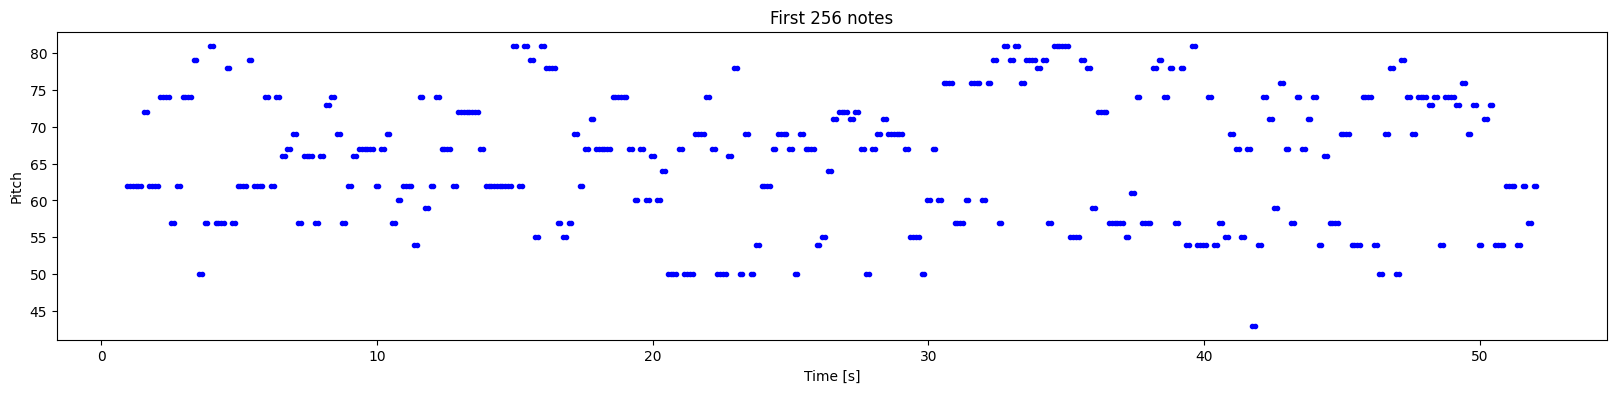

In [113]:
plot_piano_roll(notes_df, 256)

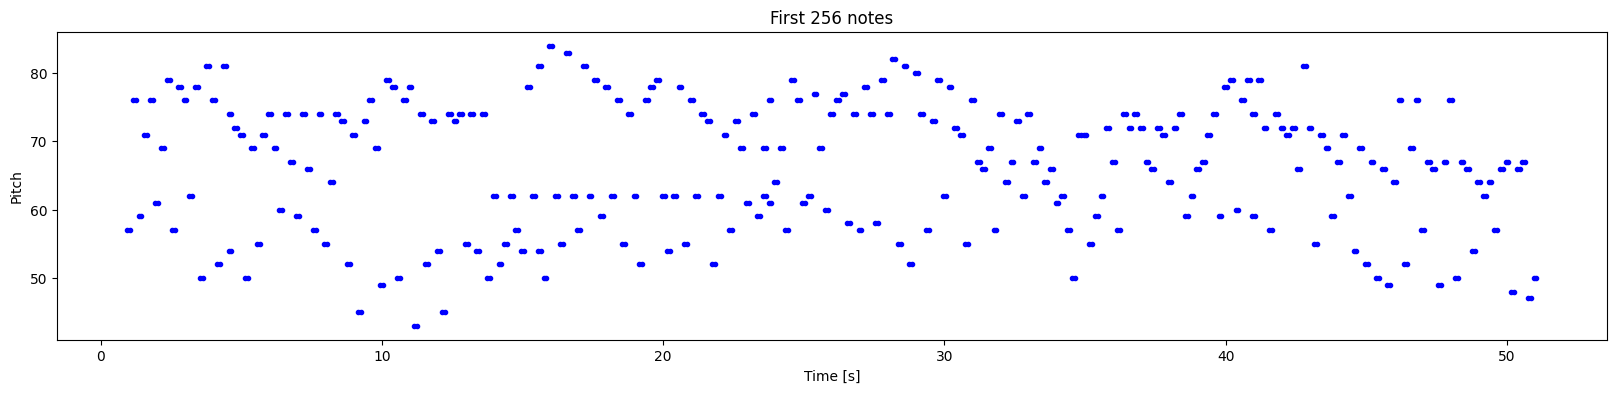

In [108]:
plot_piano_roll(orig_df, 256)